<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_Georges_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [1]:
%load_ext autoreload
%autoreload 2

Clone repo (if on colab)

In [3]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

C:\Users\tzeng1\repos\LIDC_GDRO


In [208]:
# !git pull

import necessary libraries

In [209]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import SubclassedDataset
from models import TransferModel18
from train_eval import train, evaluate
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
# import torchvision
from torchvision import transforms
import torch
from utils.image_data_utils import get_images, train_epochs, show_scatter

from umap import UMAP
from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [29]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Using cpu


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [212]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,malignancy_b,split,clusters
1295,1,6,3,1,0,3
1400,2,7,3,1,0,1
1435,3,6,3,1,1,3
1066,4,4,2,1,0,1
1244,5,4,2,1,2,1


First we load in the training data

In [213]:
train_data, cv_data, test_data = get_images(split=True, sublabels='malignancy', binary=True, device=DEVICE)

#datasets
tr = SubclassedNoduleDataset(*train_data)
cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

Next we initialize the model!

In [246]:
model = TransferModel18(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we train the model

In [247]:
epochs = 15
loss_fn = ERMLoss(model, )
train_epochs(epochs, tr_loader, cv_loader, model, loss_fn=loss_fn, num_subgroups=4, scheduler=False, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


In [216]:
test(tst_loader,model, 4)

(0.9036544850498339,
 0.9142857142857143,
 0.9722222222222222,
 0.7638888888888888,
 0.9411764705882353)

### Feature Extraction

We first save model weights (for reproducibility)

In [248]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [249]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [250]:
noduleID, data = getImages(split=False, binary=True, device=DEVICE)

Now we extract features

In [251]:
imgs = torch.stack(data[0])
model(imgs)
img_features = activation['avgpool'].squeeze()

We collect all the features in a dataframe

In [252]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)

splits = [df_splits[df_splits['noduleID'] == id]['split'].iloc[0] for id in  df_features['noduleID']]
malig = [df_splits[df_splits['noduleID'] == id]['malignancy'].iloc[0] for id in  df_features['noduleID']]

df_features['split'] = splits
df_features['malignancy'] = malig
df_features['malignancy_b'] = np.where(df_features['malignancy']>1, 1, 0)
df_features.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,506,507,508,509,510,511,512,split,malignancy,malignancy_b
0,102,0.114284,1.092620,0.045194,0.000000,0.000000,0.00000,0.016088,0.389887,0.000000,...,0.000000,1.651865,0.057312,0.025712,1.143176,0.197014,0.801935,0,0,0
1,2467,0.392762,0.819600,0.262681,0.011485,0.001726,0.00000,0.198248,0.010976,0.000000,...,0.000000,1.496611,0.011547,0.048732,1.297555,0.000000,1.878184,2,0,0
2,922,0.224796,0.987436,0.027121,0.005536,0.043899,0.00000,0.014694,0.648383,0.006404,...,0.095103,0.520295,0.000000,0.025156,0.542037,0.153384,0.159697,0,0,0
3,1695,0.286269,0.805448,0.000000,0.000000,0.000000,0.00319,0.198416,1.092871,0.000000,...,0.000513,1.210380,0.002969,0.014584,0.389263,0.255084,0.302616,0,0,0
4,1674,0.540193,0.690309,0.177131,0.168600,0.007384,0.00000,0.000000,0.074749,0.020274,...,0.000000,0.912935,0.279651,0.042771,0.830523,1.026480,0.814130,0,0,0


We again save the data for reproducibility

In [253]:
df_features.to_csv('./data/erm_cluster_cnn_features.csv')

## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [254]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]

Next we get the features in an array

In [255]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [256]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [257]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

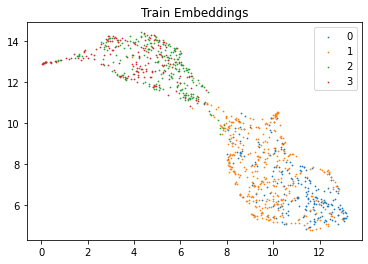

In [258]:
show_scatter(train_embeds[:, 0], train_embeds[:, 1],df_features_train['malignancy'],'Train Embeddings', 0.5)



We also do same visualization on cv and test

In [259]:
cv_test_embeds = reducer.transform(cv_test_features)

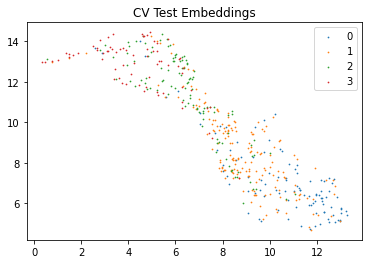

In [260]:
show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],df_features_cv_test['malignancy'],'CV Test Embeddings', 0.5)


We now save the reduce

In [261]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))




Note to lode from above file, we can call
```python
reducer = pickle.load((open(f_reducer, 'rb'))) 
```

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

(we only cluster on malignant since that is what we want)

In [262]:
train_embeds_malig = reducer.transform(train_features[df_features_train['malignancy_b'] == 1])

Text(0, 0.5, 'Silhouette Coefficients')

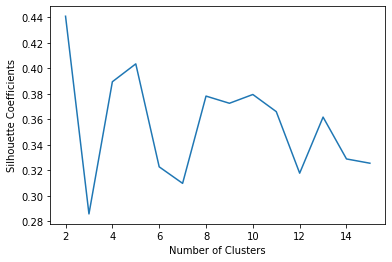

In [263]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds_malig)
  labels = gmm.predict(train_embeds_malig)
  
  silhouette_avg = silhouette_score(train_embeds_malig, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2.

In [264]:
clusterer = GaussianMixture(n_components=2, random_state=61).fit(train_embeds_malig)

We now visualize the clusters ont train

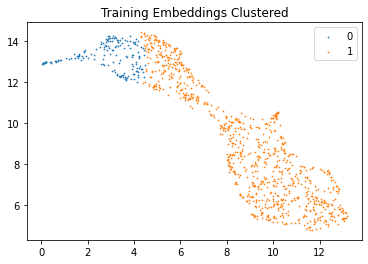

In [265]:
train_labels = clusterer.predict(train_embeds)

show_scatter(train_embeds[:, 0], train_embeds[:, 1],train_labels,'Training Embeddings Clustered', 0.5)

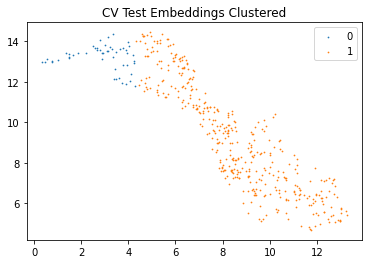

In [266]:
cv_test_labels = clusterer.predict(cv_test_embeds)

show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],cv_test_labels,'CV Test Embeddings Clustered', 0.5)

Now we save the clusterer

In [267]:
f_clusterer = './cnn_umap_clusterer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Save the labels

Now that we have the labels, we want to save them to csv we so we can train gDRO on them

In [274]:
df_features_train['clusters'] = train_labels
df_features_cv_test['clusters'] = cv_test_labels

df_clusters = pd.concat([df_features_train, df_features_cv_test])[['noduleID', 'clusters']]
df_clusters.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,noduleID,clusters
0,102,1
2,922,1
3,1695,1
4,1674,1
5,982,1


In [275]:
df_clusters = df_clusters.sort_values('noduleID')

We can add these lables to the df_splits dataframe

In [276]:
df_splits['clusters'] = [ 0 if m % 2 == 0 else 1 + c for m,c in zip(df_splits['malignancy_b'], df_clusters['clusters'])]

In [277]:
df_splits['clusters']

1295    1
1400    2
1435    1
1066    2
1244    2
       ..
1028    2
819     0
707     0
1436    2
501     0
Name: clusters, Length: 1488, dtype: int64

Now we save the csv

In [278]:
df_splits.to_csv('./data/LIDC_data_split.csv')

## Train ERM and gDRO on new models

We again get our dataloaders (but with the new sublables)

In [279]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spiculation,malignancy,malignancy_b,split,clusters
1295,1,6,3,1,0,1
1400,2,7,3,1,0,2
1435,3,6,3,1,1,1
1066,4,4,2,1,0,2
1244,5,4,2,1,2,2


In [280]:
train_data_c, cv_data_c, test_data_c = getImages(split=True, sublabels='clusters', binary=True, device=DEVICE)

#datasets
tr_c = SubclassedNoduleDataset(*train_data_c)
cv_c = SubclassedNoduleDataset(*cv_data_c)
tst_c = SubclassedNoduleDataset(*test_data_c)

#dataloaders
tr_loader_c = InfiniteDataLoader(tr_c, batch_size=512)
cv_loader_c = InfiniteDataLoader(cv_c, len(cv_c))
tst_loader_c = InfiniteDataLoader(tst_c, len(tst_c))

### ERM

In [281]:
model_ERM = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [282]:
epochs = 15
train_epochs(epochs, tr_loader_c, cv_loader_c, model_ERM, loss_fn='ERM', num_subgroups=3, scheduler=True, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15


In [283]:
test(tst_loader_c,model_ERM, 3)

(0.893687707641196, 0.9080459770114943, 1.0, 0.8181818181818182)

### GDRO

In [284]:
model_gDRO = TransferModel(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
epochs = 15
train_epochs(epochs, tr_loader_c, cv_loader_c, model_gDRO, loss_fn='gDRO', num_subgroups=3, scheduler=True, verbose=True)

In [286]:
test(tst_loader_c,model_gDRO, 3)

(0.8837209302325582, 0.92, 1.0, 0.7529411764705882)

### 50 Trials: Train Both Models for 50 Trials and Record Accuracy/Sensitivity

We first write some helper functions to help display the results

In [287]:
def run_trials(runs, epochs, loss_fn):

  accuracies = []
  for run in range(runs):
    print(f'run {run+1}/{runs}')
    model = TransferModel(device=DEVICE, pretrained=True, freeze=False)

    train_epochs(epochs, tr_loader_c, cv_loader_c, model, loss_fn=loss_fn, num_subgroups=3, scheduler=True, verbose=False)

    accuracies.append(test(tst_loader_c,model, 3, verbose=True))

  return accuracies

In [49]:
def plot_accuracies(all_accuracies, download_name):
  accuracies = list(map(lambda x:(float(i) for i in x), all_accuracies))
  df = pd.DataFrame(accuracies, columns = ['entire', '0', '1', '2','4'])

  df.to_csv(download_name)
  return df.boxplot(column=['0', '1', '2', '4','entire'], figsize = (10,10)).set_ylim(0.4, 1.01)

ERM

In [ ]:
accuracies_ERM = run_trials(30, 15, 'ERM')

gDRO

In [ ]:
accuracies_gDRO = run_trials(30, 15, 'gDRO')

Now we display the accuracies

(0.4, 1.01)

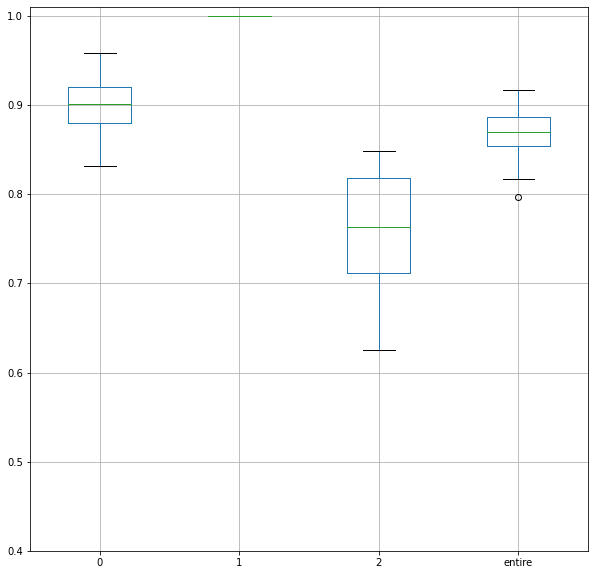

In [291]:
plot_accuracies(accuracies_ERM, './data/cluser_erm_results.csv')

(0.4, 1.01)

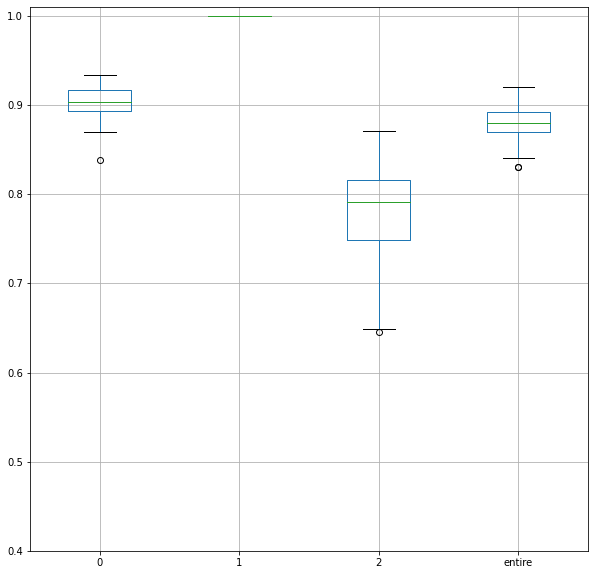

In [292]:
plot_accuracies(accuracies_gDRO, './data/cluser_gdro_results.csv')

## Now We look at what if we freeze the features trained from ERM

Above models were trained end to end. However we see what happpens if we use the frozen ERM CNN features (from before clustering) as inputs. We run 300 trials.

We first make a simple Neural Net as our model

In [39]:
import torch.nn as nn
class NeuralNetwork(nn.Module):

    # layers = int layer sizes, starting with the input layer
    def __init__(self, *layers):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        stack = []
        for i in range(len(layers) - 1):
            stack.extend([nn.Linear(layers[i], layers[i + 1]), nn.ReLU()])

        self.linear_relu_stack = nn.Sequential(*stack[:-1])

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


### Load data

In [59]:
df_features = pd.read_csv('./data/erm_cluster_cnn_features_1.csv', index_col=0)

In [60]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)

In [62]:
df = df_features.sort_values('noduleID')

In [63]:
df['clusters'] = df_splits['spic_groups']

In [64]:
df.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,507,508,509,510,511,512,split,malignancy,malignancy_b,clusters
337,1,1.423616,0.333616,0.058564,0.000000,0.000000,0.657267,0.003962,3.726149,1.417347,...,5.823934,0.000000,3.635242,0.575601,2.042758,0.164115,0,3,1,0
496,2,3.080683,4.681406,0.175545,1.078377,0.072307,0.324205,0.000000,1.084133,0.305997,...,3.915138,0.629145,3.686204,1.839621,0.000000,0.000000,0,3,1,0
519,3,0.000000,0.484235,0.209772,0.000000,0.026749,0.645972,0.000000,4.545972,0.563269,...,2.178299,0.000000,1.143802,0.265971,1.796617,0.000000,1,3,1,1
658,4,1.201508,0.843230,0.150706,0.294770,2.316583,1.228456,0.448147,2.527460,1.714548,...,1.038653,0.000000,1.693704,0.000000,0.350320,0.348847,0,2,1,1
726,5,0.704190,1.265366,0.625193,0.029190,0.568082,0.715858,0.134925,1.717047,0.011615,...,0.946970,0.000000,1.560582,0.000000,0.000000,0.534242,2,2,1,1


In [65]:
dfs = []
for i in range(3):
  dfs.append(df[df['split']==i])

In [66]:
datas = []
for d in dfs:
  X = torch.unbind(torch.tensor(d.drop(['noduleID','split', 'malignancy', 'malignancy_b','clusters'], axis=1).values, device=DEVICE, dtype=torch.float32))
  y = torch.unbind(torch.tensor(d['malignancy_b'].values, device=DEVICE))
  c = torch.unbind(torch.tensor(d['clusters'].values, device=DEVICE))
  datas.append((X,y,c))

In [67]:
train_data_e, cv_data_e, test_data_e = datas

#datasets
tr_e = SubclassedNoduleDataset(*train_data_e)
cv_e = SubclassedNoduleDataset(*cv_data_e)
tst_e = SubclassedNoduleDataset(*test_data_e)

#dataloaders
tr_loader_e = InfiniteDataLoader(tr_e, batch_size=512)
cv_loader_e = InfiniteDataLoader(cv_e, len(cv_e))
tst_loader_e = InfiniteDataLoader(tst_e, len(tst_e))

In [68]:
model = NeuralNetwork(512, 64, 36, 2).to(DEVICE)

In [73]:
len(train_data_e[2])

1040

### Run trials

Apologies for the spaghetti code

In [46]:
def run_trials_2(runs, epochs, loss_fn):

  accuracies = []
  for run in range(runs):
    # print(f'run {run+1}/{runs}')
    model = NeuralNetwork(512, 64, 36, 2).to(DEVICE)

    train_epochs(epochs, tr_loader_e, cv_loader_e, model, loss_fn=loss_fn, num_subgroups=4, scheduler=True, verbose=False)

    accuracies.append(test(tst_loader_e,model, 4, verbose=False))

  return accuracies

In [92]:
acc_ERM = run_trials_2(300, 15, 'ERM')

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epo

Epoch 3/15
Epoch 4/15
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-05.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-06.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-07.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epo

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 1

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 2.0000e-05.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 4.0

Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/

Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.
Epoch 14/15
Epoch 15/15
Ep

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epo

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/1

Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14

Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-06.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-07.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Ep

Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate

Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 2.0000e-05.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 2.0000e-05.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epo

(0.4, 1.01)

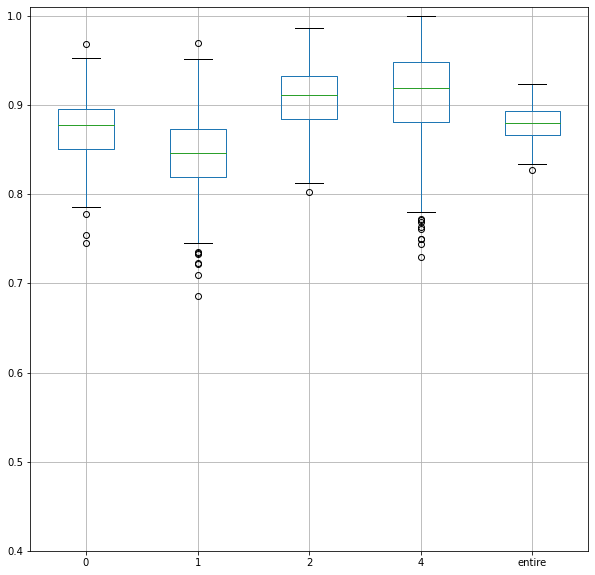

In [93]:
plot_accuracies(acc_ERM, './data/cluser_fixed_erm_spic_results.csv')

In [94]:
acc_GDRO = run_trials_2(300, 15, 'gDRO')

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epo

Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-05.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-06.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-07.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-06.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing lea

Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-06.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-07.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Ep

Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Ep

Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-06.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-07.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Ep

Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06

Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-06.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reduc

Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 1.0000e-04.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 2.0000e-05.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Ep

Epoch 00015: reducing learning rate of group 0 to 2.0000e-05.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of 

Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 1

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-06.
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-07.
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-07.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 00011: reducing learning r

Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-06.
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/15
Epo

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
Epoch 13/15
Epoch 14/15
Epoch 15/15
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 13/15
Epoch 14/15
Epo

(0.4, 1.01)

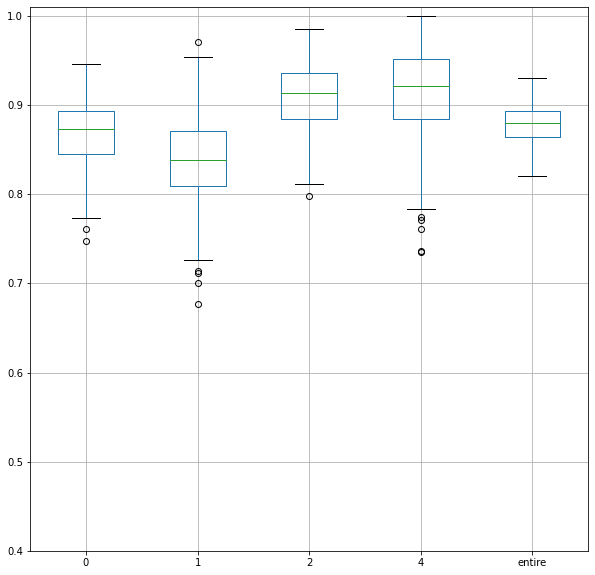

In [95]:
plot_accuracies(acc_GDRO, './data/cluser_fixed_gdro_spic_results.csv')